<a href="https://colab.research.google.com/github/basarr/monte-carlo-engine/blob/main/06_variance_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Option Pricing with Antithetic Variates

This notebook prices a European call option under Geometric Brownian Motion (GBM)
and demonstrates variance reduction using antithetic variates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Option and model parameters
S0 = 100.0      # initial stock price
K = 100.0       # strike
T = 1.0         # maturity (years)
r = 0.05        # risk-free rate
sigma = 0.2     # volatility

np.random.seed(42)

In [3]:
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

bs_price = black_scholes_call(S0, K, T, r, sigma)
bs_price

np.float64(10.450583572185565)

## Standard Monte Carlo Estimator

We first price the option using plain Monte Carlo simulation
to establish a baseline variance.

In [4]:
n_paths = 200_000

Z = np.random.randn(n_paths)

ST = S0 * np.exp(
    (r - 0.5 * sigma**2) * T
    + sigma * np.sqrt(T) * Z
)

payoff = np.maximum(ST - K, 0)
disc_payoff = np.exp(-r * T) * payoff

mc_price_standard = np.mean(disc_payoff)
var_standard = np.var(disc_payoff, ddof=1)

mc_price_standard, var_standard

(np.float64(10.462392128395539), np.float64(216.30920776161898))

The discounted payoff distribution is highly skewed:
- many paths produce zero payoff
- a few paths produce very large payoffs

This leads to high estimator variance and slow convergence.

## Antithetic Variates

For each standard normal draw $Z$, we also use $-Z$.

- Both have the same distribution
- Their payoffs are negatively correlated
- Averaging them preserves unbiasedness while reducing variance

In [5]:
n_pairs = 100_000   # each pair produces two paths

Z = np.random.randn(n_pairs)

# Positive and negative shocks
ST_pos = S0 * np.exp(
    (r - 0.5 * sigma**2) * T
    + sigma * np.sqrt(T) * Z
)

ST_neg = S0 * np.exp(
    (r - 0.5 * sigma**2) * T
    - sigma * np.sqrt(T) * Z
)

payoff_pos = np.maximum(ST_pos - K, 0)
payoff_neg = np.maximum(ST_neg - K, 0)

disc_payoff_pos = np.exp(-r * T) * payoff_pos
disc_payoff_neg = np.exp(-r * T) * payoff_neg

# Antithetic estimator
antithetic_payoff = 0.5 * (disc_payoff_pos + disc_payoff_neg)

mc_price_antithetic = np.mean(antithetic_payoff)
var_antithetic = np.var(antithetic_payoff, ddof=1)

mc_price_antithetic, var_antithetic

(np.float64(10.451767620044448), np.float64(54.0532320219406))

We now compare estimator variance between standard Monte Carlo
and antithetic Monte Carlo.

In [6]:
var_antithetic / var_standard

np.float64(0.24988872448513302)

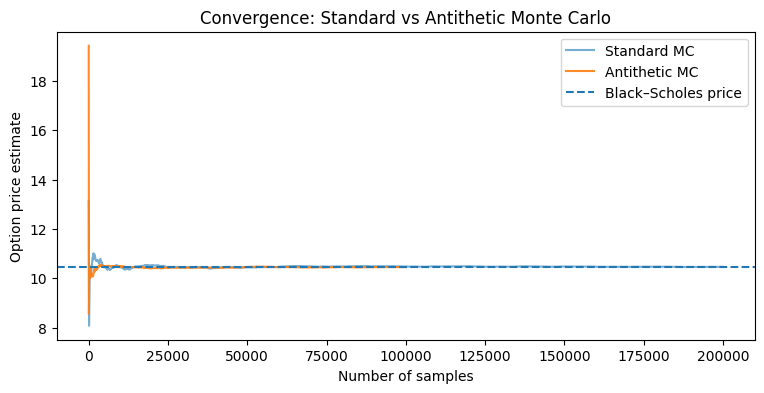

In [7]:
cum_mean_standard = np.cumsum(disc_payoff) / np.arange(1, len(disc_payoff) + 1)
cum_mean_anti = np.cumsum(antithetic_payoff) / np.arange(1, len(antithetic_payoff) + 1)

idx_std = np.linspace(1, len(cum_mean_standard), 2000, dtype=int) - 1
idx_anti = np.linspace(1, len(cum_mean_anti), 2000, dtype=int) - 1

plt.figure(figsize=(9, 4))
plt.plot(idx_std + 1, cum_mean_standard[idx_std], alpha=0.6, label="Standard MC")
plt.plot(idx_anti + 1, cum_mean_anti[idx_anti], alpha=0.9, label="Antithetic MC")
plt.axhline(bs_price, linestyle="--", label="Black–Scholes price")
plt.xlabel("Number of samples")
plt.ylabel("Option price estimate")
plt.title("Convergence: Standard vs Antithetic Monte Carlo")
plt.legend()
plt.show()

## Summary

- Standard Monte Carlo provides an unbiased but noisy estimator
- Antithetic variates reduce variance by exploiting symmetry in normal shocks
- The estimator remains unbiased while converging faster
- Variance reduction is achieved without increasing computational cost